In [2]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import numpy as np
import matplotlib.patches as patches
from pathlib import Path
import re

In [68]:

# ---- grids / mappings ----
NUM_SPACING = 29          # adjust if needed
NUM_WIDTH   = 10

spacing_um = np.linspace(2.0, 30.0, NUM_SPACING)   # 0→2 µm, 28→30 µm
width_um   = np.linspace(1.0, 10.0, NUM_WIDTH)     # 0→1 µm, 9→10 µm
doping_map = {
    0: "intrinsic",
    1: "1e15 cm^-3",
    2: "1e16 cm^-3",
    3: "1e17 cm^-3",
}
mode_map = {0: "A0", 1: "S0"}

def load_measure(path, value_name):
    # CSV has no header; five columns as described
    df = pd.read_csv(path, header=None, names=[
        "spacing_idx", "width_idx", "doping_idx", "mode_idx", value_name
    ])
    # attach physical labels (keep indices too)
    df["spacing_um"] = df["spacing_idx"].map({i:v for i,v in enumerate(spacing_um)})
    df["width_um"]   = df["width_idx"].map({i:v for i,v in enumerate(width_um)})
    df["doping"]     = df["doping_idx"].map(doping_map)
    df["mode"]       = df["mode_idx"].map(mode_map)
    return df

# Examples:
Qdf     = load_measure("./data/Q.csv",     "Q")
fdf     = load_measure("./data/freq.csv",  "freq_Hz")
eg_ksq1_df = load_measure("./data/eg_ksq1.csv", "eg_ksq1")   # unitless (e.g., 0.006 = 0.6%)
eg_ksq2_df = load_measure("./data/eg_ksq2.csv", "eg_ksq2")   # unitless (e.g., 0.006 = 0.6%)
k2fd_df = load_measure("./data/k2_fd.csv", "k2_fd")
Lm_df   = load_measure("./data/Lm.csv",    "Lm_H")
Rm_df   = load_measure("./data/Rm.csv",    "Rm_ohm")
Cm_df   = load_measure("./data/Cm.csv",    "Cm_F")



In [69]:
# sanity peek
Qdf.head(10)

datasets = {
    'Qdf': Qdf,
    'fdf': fdf,
    'eg_ksq1_df': eg_ksq1_df,
    'eg_ksq2_df': eg_ksq2_df,
    'k2fd_df': k2fd_df,
    'Lm_df': Lm_df,
    'Rm_df': Rm_df,
    'Cm_df': Cm_df,
}

value_columns = {
    'Qdf': 'Q',
    'fdf': 'freq_Hz',
    'eg_ksq1_df': 'eg_ksq1',
    'eg_ksq2_df': 'eg_ksq2',
    'k2fd_df': 'k2_fd',
    'Lm_df': 'Lm_H',
    'Rm_df': 'Rm_ohm',
    'Cm_df': 'Cm_F',
}

for name, df in datasets.items():
    column = value_columns[name]
    non_nan = int(df[column].notna().sum())
    total = df[column].size
    print(f"{name}.{column}: {non_nan} non-NaN values out of {total}")


Qdf.Q: 93 non-NaN values out of 2320
fdf.freq_Hz: 93 non-NaN values out of 2320
eg_ksq1_df.eg_ksq1: 93 non-NaN values out of 2320
eg_ksq2_df.eg_ksq2: 93 non-NaN values out of 2320
k2fd_df.k2_fd: 93 non-NaN values out of 2320
Lm_df.Lm_H: 93 non-NaN values out of 2320
Rm_df.Rm_ohm: 93 non-NaN values out of 2320
Cm_df.Cm_F: 93 non-NaN values out of 2320


In [70]:
keys = ["spacing_idx","width_idx","doping_idx","mode_idx","spacing_um","width_um"]
df = (Qdf[keys+["Q"]]
      .merge(fdf[keys+["freq_Hz"]],   on=keys, how="inner")
      .merge(eg_ksq1_df[keys+["eg_ksq1"]], on=keys, how="inner")
      .merge(eg_ksq2_df[keys+["eg_ksq2"]], on=keys, how="inner")
     .merge(k2fd_df[keys+["k2_fd"]],   on=keys, how="inner"))
# then use the plotting code from the merged-df section
df.head()

,spacing_idx,width_idx,doping_idx,mode_idx,spacing_um,width_um,Q,freq_Hz,eg_ksq1,eg_ksq2,k2_fd
0,0,0,0,0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
1,0,0,0,1,2.0,1.0,NaN,NaN,NaN,NaN,NaN
2,0,0,1,0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
3,0,0,1,1,2.0,1.0,NaN,NaN,NaN,NaN,NaN
4,0,0,2,0,2.0,1.0,NaN,NaN,NaN,NaN,NaN


In [63]:
#totally forget where this data is from 
undamped_data = {
    "lambda": [7.000E-06,8.000E-06,9.000E-06,1.000E-05,1.100E-05,1.200E-05,1.300E-05,1.400E-05,1.50E-05,1.60E-05,2.00E-05,2.60E-05,4.00E-05,8.00E-05],
    "hGan/Lambda": [0.63, 0.55, 0.49, 0.440, 0.400, 0.367, 0.338,0.314,0.293,0.275,0.220,0.169, .110,.055],
    "Antisymmetric ksq%": [0.055, 0.081, 0.103, 0.121, 0.134, 0.143, 0.148,0.150 ,0.152,0.149, 0.134,0.105,.064,.031],
    "Symmetric ksq%": [0.275, 0.358, 0.448, 0.533, 0.602, 0.643, 0.652,0.641,0.624,0.604,.56,.552,0.567,.576]
}
undamped_df = pd.DataFrame(undamped_data)

In [71]:
#import data/Popa5-4.csv 
popa_df = pd.read_csv('./data/Popa5-5.csv')
popa_df = popa_df.rename(columns={'x': 'hGan/Lambda'})
popa_df.head()


,hGan/Lambda,S0,S0_be,A0_be,A0
0,0.01363,-0.00299,0.87393,-0.03271,0.01118
1,0.04312,0.02760,0.82291,-0.00908,0.04246
2,0.06214,0.04722,0.79620,0.00083,0.06707
3,0.06863,0.05399,0.78745,0.00378,0.07779
4,0.07550,0.06123,0.77819,0.00681,0.09124


Gather k^2 entries where spacing and width track closest to $\lambda/4$ (spacing equals width). This enables comparison of new app data to Fig-3-4 of Popa Thesis where the geometry is contrained 

In [ ]:
#Cell 97
# Gather k^2 entries where spacing and width track closest to \lambda/4 (spacing approximately equals width).

hGaN_um   = 4.4

Nd_idx    = 3          # 1e15 cm^-3
modes     = {0:'A0', 1:'S0'}
style     = {0:'--',  1:'-'}   # A0 dashed, S0 solid
closest_lambda_quarter = df[(df['k2_fd'].notna()) & (df['doping_idx'] == Nd_idx)].copy()
closest_lambda_quarter['lambda_um'] = 2.0 * (closest_lambda_quarter['spacing_um'] + closest_lambda_quarter['width_um'])
closest_lambda_quarter['hGaN/lambda'] = hGaN_um / closest_lambda_quarter['lambda_um']
closest_lambda_quarter['width_spacing_err'] = (closest_lambda_quarter['width_um'] - closest_lambda_quarter['spacing_um']).abs()

matching_err_threshold = 0.2  # width-spacing tolerance in um
mode_label_map = {0: 'A0', 1: 'S0'}
lambda_slice = closest_lambda_quarter[closest_lambda_quarter['width_spacing_err'] <= matching_err_threshold].copy()
lambda_slice['mode_label'] = lambda_slice['mode_idx'].map(mode_label_map)

base_index = ['hGaN/lambda', 'lambda_um', 'width_um', 'spacing_um']
value_sets = [
    ('k2_fd', {'A0': 'ksq_A0_fd', 'S0': 'ksq_S0_fd'}),
    ('eg_ksq1', {'A0': 'ksq1_A0', 'S0': 'ksq1_S0'}),
    ('eg_ksq2', {'A0': 'ksq2_A0', 'S0': 'ksq2_S0'}),
]
pivot_tables = []
for value_col, rename_map in value_sets:
    pivot_tables.append(
        lambda_slice
        .pivot_table(
            index=base_index,
            columns='mode_label',
            values=value_col,
            aggfunc='first'
        )
        .rename(columns=rename_map)
    )

lambda_quarter_df = (
    pd.concat(pivot_tables, axis=1)
    .reset_index()
    .rename_axis(None, axis=1)
    .reindex(columns=base_index + ['ksq_A0_fd', 'ksq_S0_fd', 'ksq1_A0', 'ksq1_S0', 'ksq2_A0', 'ksq2_S0'])
    .sort_values('lambda_um')
)

lambda_quarter_df


,hGaN/lambda,lambda_um,width_um,spacing_um,ksq_A0_fd,ksq_S0_fd,ksq1_A0,ksq1_S0,ksq2_A0,ksq2_S0
8,0.550000,8.0,2.0,2.0,0.114369,0.367666,0.356372,1.050425,0.080914,0.310010
7,0.366667,12.0,3.0,3.0,0.164865,0.643865,0.211324,0.727146,0.143148,0.642173
6,0.275000,16.0,4.0,4.0,0.178088,0.606865,0.165649,0.643279,0.149373,0.604547
5,0.220000,20.0,5.0,5.0,0.174488,0.565069,0.165083,0.586627,0.133570,0.560766
4,0.183333,24.0,6.0,6.0,0.172091,0.556707,0.182833,0.575916,0.114117,0.551702
3,0.157143,28.0,7.0,7.0,0.170897,0.559096,0.206374,0.579188,0.096759,0.554011
2,0.137500,32.0,8.0,8.0,0.172105,0.563875,0.258105,0.586839,0.024684,0.558948
1,0.122222,36.0,9.0,9.0,0.174515,0.568653,0.252926,0.594693,0.071860,0.563924
0,0.110000,40.0,10.0,10.0,0.178126,0.573431,0.272803,0.601757,0.063301,0.568165


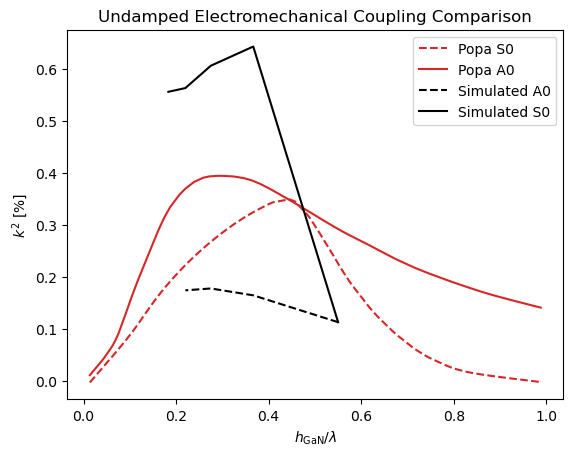

In [81]:
#Cell 197
# Gather k^2 entries where spacing and width track closest to \lambda/4 (spacing approximately equals width).

hGaN_um   = 4.4

Nd_idx    = 0          # undamped / intrinsic
closest_lambda_quarter = df[(df['k2_fd'].notna()) & (df['doping_idx'] == Nd_idx)].copy()
closest_lambda_quarter['lambda_um'] = 2.0 * (closest_lambda_quarter['spacing_um'] + closest_lambda_quarter['width_um'])
closest_lambda_quarter['hGaN/lambda'] = hGaN_um / closest_lambda_quarter['lambda_um']
closest_lambda_quarter['width_spacing_err'] = (closest_lambda_quarter['width_um'] - closest_lambda_quarter['spacing_um']).abs()

matching_err_threshold = 0.2  # width-spacing tolerance in um
mode_label_map = {0: 'A0', 1: 'S0'}
undamped_slice = closest_lambda_quarter[closest_lambda_quarter['width_spacing_err'] <= matching_err_threshold].copy()
undamped_slice['mode_label'] = undamped_slice['mode_idx'].map(mode_label_map)

base_index = ['hGaN/lambda', 'lambda_um', 'width_um', 'spacing_um']
undamped_k2_df = (
    undamped_slice
    .pivot_table(
        index=base_index,
        columns='mode_label',
        values='k2_fd',
        aggfunc='first'
    )
    .reset_index()
    .rename_axis(None, axis=1)
    .rename(columns={'A0': 'ksq_A0_fd_undamped', 'S0': 'ksq_S0_fd_undamped'})
    .sort_values('lambda_um')
)

undamped_k2_df

fig, ax = plt.subplots()

# Popa reference curves (Top vs. Bottom electrode versions)
popa_columns = [
    ('S0', 'tab:red', '--', 'Popa S0 '),
    #('S0_be', 'tab:red', '-', 'Popa S0 (bottom electrode)'),
    ('A0', 'tab:red', '-', 'Popa A0 '),
    #('A0_be', 'tab:red', '-', 'Popa A0 (bottom electrode)'),
    #('S0_be', 'k', '--', 'Popa S0 (bottom electrode)'),
    #('A0_be', 'gray', '--', 'Popa A0 (bottom electrode)'),
]
for column, color, linestyle, label in popa_columns:
    if column in popa_df.columns:
        ax.plot(
            popa_df['hGan/Lambda'],
            popa_df[column],
            color=color,
            linestyle=linestyle,
            label=label
        )

# Simulation (undamped) curves
ax.plot(
    undamped_k2_df['hGaN/lambda'],
    undamped_k2_df['ksq_A0_fd_undamped'],
    color='k',
    linestyle='--',
    #marker='o',
    label='Simulated A0'

)
ax.plot(
    undamped_k2_df['hGaN/lambda'],
    undamped_k2_df['ksq_S0_fd_undamped'],
    color='k',
    linestyle='-',
    #marker='s',
    label='Simulated S0'

)

ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title('Undamped Electromechanical Coupling Comparison')
ax.set_ylabel(r'$k^2$ [%]')
ax.legend(loc='best')


In [67]:
undamped_k2_df

,hGaN/lambda,lambda_um,width_um,spacing_um


Old plot for comparison 

Note this was with geometry that always had width = $\lambda / 4 $

<img src="SavedFigs/ksq_wdth_lmbdaOver_4.png" alt="Test setup" width="420">



### check eigenmode $k^2$ (kind of works)

Text(0, 0.5, '$k^2$ [%]')

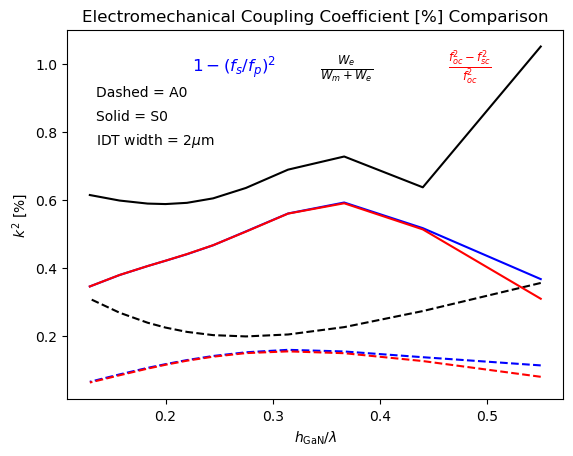

In [40]:
#cell 98 
Nd_idx    = 3         # 1e17 cm^-3
# NaN/Inf guard for each plot
#dfA0 = df[ df["doping_idx"]==Nd_idx & (df["mode_idx"] == 0)] .copy()
#dfS0 = df[ df["doping_idx"]==Nd_idx & (df["mode_idx"] == 1)] .copy()
width_sel = 2.0
# NaN/Inf guard for each plot
dfA0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 0)] .copy()
dfS0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 1)] .copy()
df_k2_A0 = dfA0[np.isfinite(dfA0['k2_fd'])].copy()
df_k2_S0 = dfS0[np.isfinite(dfS0['k2_fd'])].copy()

# derive axes
df_k2_A0["lambda_um"]     = 2.0*(df_k2_A0["spacing_um"] + df_k2_A0["width_um"])
df_k2_A0['hGaN/lambda'] = hGaN_um / df_k2_A0["lambda_um"]
df_k2_S0["lambda_um"]     = 2.0*(df_k2_S0["spacing_um"] + df_k2_S0["width_um"])
df_k2_S0['hGaN/lambda'] = hGaN_um / df_k2_S0["lambda_um"]


fig, ax = plt.subplots()
# curves of Nd = 1e16 are red, with red text stating Nd = 1e16
#curves of Nd = 1e15 are blue, with blue text stating Nd = 1e15
# undamped curves are black, with black text stating 'undamped'
# A0 modes are dashed, S0 modes are solid

ax.plot(df_k2_A0['hGaN/lambda'], df_k2_A0['k2_fd'], color='b', linestyle='--')
ax.plot(df_k2_S0['hGaN/lambda'], df_k2_S0['k2_fd'], color='b', linestyle='-')   
ax.plot(df_k2_A0['hGaN/lambda'], df_k2_A0['eg_ksq1'], color='k', linestyle='--')
ax.plot(df_k2_S0['hGaN/lambda'], df_k2_S0['eg_ksq1'], color='k', linestyle='-')
ax.plot(df_k2_A0['hGaN/lambda'], df_k2_A0['eg_ksq2'], color='r', linestyle='--')
ax.plot(df_k2_S0['hGaN/lambda'], df_k2_S0['eg_ksq2'], color='r', linestyle='-')
# Annotations
# Nd annotations in figure coordinates (left, midway up)

ax.annotate(r'$1-(f_s/f_p)^2$', xy=(0.3, 0.8), xycoords='figure fraction', color='b', fontsize=12)
ax.annotate(r'$\frac{W_e}{W_m+W_e}$', xy=(0.5, 0.8), xycoords='figure fraction', color='k', fontsize=12)
ax.annotate(r'$\frac{f_{oc}^2 - f_{sc}^2}{f_{oc}^2}$', xy=(0.7, 0.8), xycoords='figure fraction', color='r', fontsize=12)
# Mode annotations
ax.annotate('Dashed = A0', xy=(0.15, 0.75), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.7), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'IDT width = $2\mu$m', xy=(0.15, 0.65), xycoords='figure fraction', color='k', fontsize=10)

ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title('Electromechanical Coupling Coefficient [%] Comparison')
ax.set_ylabel(r'$k^2$ [%]')

Text(0, 0.5, '$k^2$ [%]')

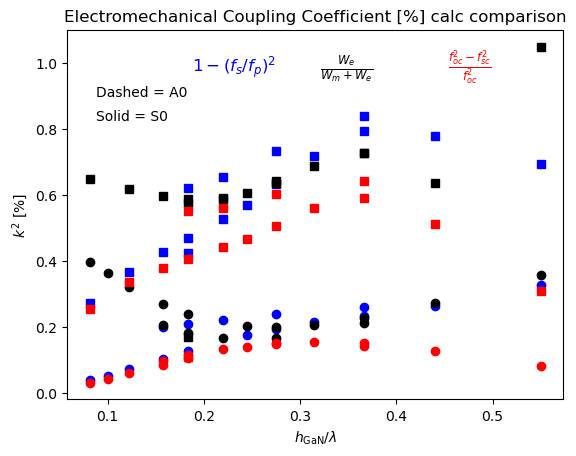

In [54]:
#Cell 99
Nd_idx    = 3         # 1e17 cm^-3
width_sel = 2.0
# NaN/Inf guard for each plot
#dfA0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 0)] .copy()
#dfS0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 1)] .copy()
dfA0 = df[ df["doping_idx"]==Nd_idx & (df["mode_idx"] == 0)] .copy()
dfS0 = df[ df["doping_idx"]==Nd_idx & (df["mode_idx"] == 1)] .copy()
df_k2_A0 = dfA0[np.isfinite(dfA0['k2_fd'])].copy()
df_k2_S0 = dfS0[np.isfinite(dfS0['k2_fd'])].copy()

# derive axes
df_k2_A0["lambda_um"]     = 2.0*(df_k2_A0["spacing_um"] + df_k2_A0["width_um"])
df_k2_A0['hGaN/lambda'] = hGaN_um / df_k2_A0["lambda_um"]
df_k2_S0["lambda_um"]     = 2.0*(df_k2_S0["spacing_um"] + df_k2_S0["width_um"])
df_k2_S0['hGaN/lambda'] = hGaN_um / df_k2_S0["lambda_um"]


fig, ax = plt.subplots()

ax.plot(df_k2_A0['hGaN/lambda'], df_k2_A0['k2_fd'], color='b', linestyle='none', marker='o')
ax.plot(df_k2_S0['hGaN/lambda'], df_k2_S0['k2_fd'], color='b', linestyle='none', marker='s')
ax.plot(df_k2_A0['hGaN/lambda'], df_k2_A0['eg_ksq1'], color='k', linestyle='none', marker='o')
ax.plot(df_k2_S0['hGaN/lambda'], df_k2_S0['eg_ksq1'], color='k', linestyle='none', marker='s')
ax.plot(df_k2_A0['hGaN/lambda'], df_k2_A0['eg_ksq2'], color='r', linestyle='none', marker='o')
ax.plot(df_k2_S0['hGaN/lambda'], df_k2_S0['eg_ksq2'], color='r', linestyle='none', marker='s')
# Annotations
# Nd annotations in figure coordinates (left, midway up)

ax.annotate(r'$1-(f_s/f_p)^2$', xy=(0.3, 0.8), xycoords='figure fraction', color='b', fontsize=12)
ax.annotate(r'$\frac{W_e}{W_m+W_e}$', xy=(0.5, 0.8), xycoords='figure fraction', color='k', fontsize=12)
ax.annotate(r'$\frac{f_{oc}^2 - f_{sc}^2}{f_{oc}^2}$', xy=(0.7, 0.8), xycoords='figure fraction', color='r', fontsize=12)
# Mode annotations
ax.annotate('Dashed = A0', xy=(0.15, 0.75), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.7), xycoords='figure fraction', color='k', fontsize=10)


ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title('Electromechanical Coupling Coefficient [%] calc comparison')
ax.set_ylabel(r'$k^2$ [%]')

Text(0, 0.5, '$k^2$ [%]')

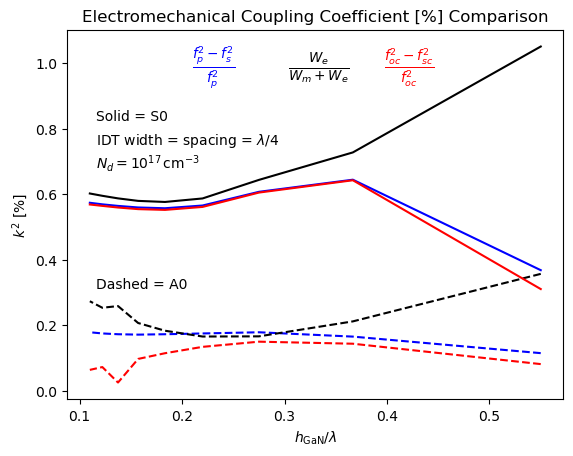

In [85]:
#cell 101 
Nd_idx    = 3         # 1e17 cm^-3
fig, ax = plt.subplots()

# A0 modes are dashed, S0 modes are solid
ax.plot(lambda_quarter_df["hGaN/lambda"], lambda_quarter_df["ksq_A0_fd"], color='b', linestyle='--')#, label = r'$k^2 [\%]$')
ax.plot(lambda_quarter_df["hGaN/lambda"], lambda_quarter_df["ksq_S0_fd"], color='b', linestyle='-')#, label = r'$k^2 [\%]$')
ax.plot(lambda_quarter_df["hGaN/lambda"], lambda_quarter_df["ksq1_A0"], color='k', linestyle='--')#, label = r'$k^2 [\%]$')
ax.plot(lambda_quarter_df["hGaN/lambda"], lambda_quarter_df["ksq1_S0"], color='k', linestyle='-')#, label = r'$k^2 [\%]$')
ax.plot(lambda_quarter_df["hGaN/lambda"], lambda_quarter_df["ksq2_A0"], color='r', linestyle='--')#, label = r'$k^2 [\%]$')
ax.plot(lambda_quarter_df["hGaN/lambda"], lambda_quarter_df["ksq2_S0"], color='r', linestyle='-')#, label = r'$k^2 [\%]$')

# Annotations

ax.annotate(r'$\frac{f_{p}^2 - f_{s}^2}{f_{p}^2}$', xy=(0.3, 0.8), xycoords='figure fraction', color='b', fontsize=14)
ax.annotate(r'$\frac{W_e}{W_m+W_e}$', xy=(0.45, 0.8), xycoords='figure fraction', color='k', fontsize=14)
ax.annotate(r'$\frac{f_{oc}^2 - f_{sc}^2}{f_{oc}^2}$', xy=(0.6, 0.8), xycoords='figure fraction', color='r', fontsize=14)
# Mode annotations
ax.annotate('Dashed = A0', xy=(0.15, 0.35), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.7), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'IDT width = spacing = $\lambda/4$', xy=(0.15, 0.65), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'$N_d = 10^{17} \,\text{cm}^{-3}$', xy=(0.15, 0.6), xycoords='figure fraction', color='k', fontsize=10)
ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title('Electromechanical Coupling Coefficient [%] Comparison')
ax.set_ylabel(r'$k^2$ [%]')
#optional Popa comparison
#ax.plot(popa_df["hGan/Lambda"], popa_df["S0"], color='g', linestyle='-')#, label = r'$k^2 [\%]$')
#ax.plot(popa_df["hGan/Lambda"], popa_df["A0"], color='g', linestyle='--')
#ax.set_xlim(0, 0.6)

### plot $f\cdot Q$ product for $N_d = 10^{15}$ at width = $2\mu m$ 

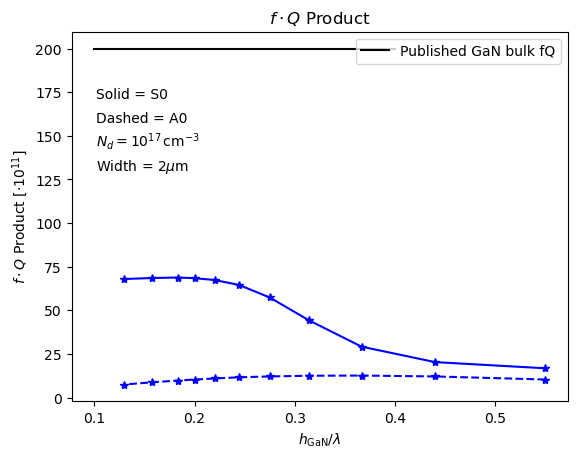

In [ ]:
#Cell 201
Nd_idx    = 3         # 1e17 cm^-3
width_sel = 2.0
dfA0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 0)] .copy()
dfS0 = df[(df["width_um"]==width_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 1)] .copy()
# NaN/Inf guard for each plot
df_Q_A0 = dfA0[np.isfinite(dfA0['Q'])].copy()
df_Q_S0 = dfS0[np.isfinite(dfS0['Q'])].copy()
# derive axes
df_Q_A0["lambda_um"]     = 2.0*(df_Q_A0["spacing_um"] + df_Q_A0["width_um"])
df_Q_A0['hGaN/lambda'] = hGaN_um / df_Q_A0["lambda_um"]
df_Q_S0["lambda_um"]     = 2.0*(df_Q_S0["spacing_um"] + df_Q_S0["width_um"])
df_Q_S0['hGaN/lambda'] = hGaN_um / df_Q_S0["lambda_um"]
# Plot material best-case using Popa Figure 5-24 
# acoustive velcity = 7990 m/s, f = v/λ, fQ = 2*10^13
# hGaN / lambda = hGaN *f/v 
# # f = the range over the data we have 
f1 = df_Q_A0['freq_Hz'].min()
f2 = df_Q_A0['freq_Hz'].max()
#v = 7990 
hGaN = 4.4e-6

fig, ax = plt.subplots()
# curves of Nd = 1e16 are red, with red text stating Nd = 1e16
#curves of Nd = 1e15 are blue, with blue text stating Nd = 1e15
# undamped curves are black, with black text stating 'undamped'
# A0 modes are dashed, S0 modes are solid
ax.plot(df_Q_A0['hGaN/lambda'], df_Q_A0['Q']*df_Q_A0['freq_Hz']/1e11, color='b', linestyle='--', marker='*')#, label = r'$k^2 [\%]$')
ax.plot(df_Q_S0['hGaN/lambda'], df_Q_S0['Q']*df_Q_S0['freq_Hz']/1e11, color='b', linestyle='-', marker='*')#, label = r'$k^2 [\%]$')
#ax.plot([hGaN*f1/v, hGaN*f2/v], [2.0e13/1e11, 2.0e13/1e11], color='k', linestyle='-', label = 'GaN bulk fQ')
ax.plot([.1,.4], [2.0e13/1e11, 2.0e13/1e11], color='k', linestyle='-', label = 'Published GaN bulk fQ')
# Mode annotations
ax.annotate('Dashed = A0', xy=(0.15, 0.7), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.75), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'$N_d = 10^{17} \,\text{cm}^{-3}$', xy=(0.15, 0.65), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(f'Width = {int(width_sel)}'+ r'$\mu$' +'m', xy=(0.15, 0.6), xycoords='figure fraction', color='k', fontsize=10)
ax.set_xlabel(r'$h_{\mathrm{GaN}}/\lambda$')
ax.set_title(r'$f\cdot Q$ Product')
ax.set_ylabel(r'$f\cdot Q$ Product $[\cdot 10^{11}]$')
#ax.set_ylim([1, 4])
ax.legend(loc='upper right')

<img src="SavedFigs/fig-5-24-popa.png" alt="Test setup" width="420">

### plot $k^2$ and $Q$ as width varies for a fixed $\lambda$

Text(0, 0.5, '$Q$')

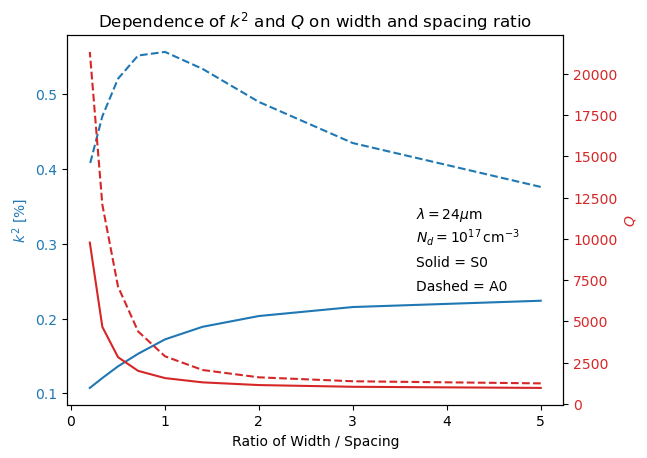

In [87]:
#Cell 202
lambda_sel = 24.0
Nd_idx    = 3          # 1e15 cm^-3
df["lambda_um"]     = 2.0*(df["spacing_um"] + df["width_um"])
# keep only the relevant slice
dfA0 = df[(df["lambda_um"]==lambda_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 0)] .copy()
dfS0 = df[(df["lambda_um"]==lambda_sel) & (df["doping_idx"]==Nd_idx) & (df["mode_idx"] == 1)] .copy()

# NaN/Inf guard for each plot
dfA0 = dfA0[np.isfinite(dfA0['k2_fd'])].copy()
dfS0 = dfS0[np.isfinite(dfS0['k2_fd'])].copy()

# derive axes
dfA0['w_s_ratio'] = dfA0["width_um"] / dfA0["spacing_um"]
dfS0['w_s_ratio'] = dfS0["width_um"] / dfS0["spacing_um"]
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot( dfA0['w_s_ratio'], dfA0['k2_fd'], color="tab:blue")#, marker='*')
ax2.plot( dfA0['w_s_ratio'], dfA0['Q'], color = "tab:red")
ax.plot( dfS0['w_s_ratio'], dfS0['k2_fd'], color="tab:blue", linestyle='--')#,marker='o')
ax2.plot( dfS0['w_s_ratio'], dfS0['Q'], color = "tab:red", linestyle='--')
ax.annotate(r'$\lambda= 24\mu$m', xy=(0.65, 0.5), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'$N_d = 10^{17} \,\text{cm}^{-3}$', xy=(0.65, 0.45), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Dashed = A0', xy=(0.65, 0.35), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.65, 0.4), xycoords='figure fraction', color='k', fontsize=10)
ax.set_xlabel(r'Ratio of Width / Spacing')
ax.tick_params(axis="y", labelcolor="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax.set_title(r'Dependence of $k^2$ and $Q$ on width and spacing ratio')
ax.set_ylabel(r'$k^2$ [%]', color="tab:blue")
ax2.set_ylabel(r'$Q$', color="tab:red")
#to do: add product of two curves on a third axis that isn't shown, but label peak value on the plot
#and / or create a new plot with same x axis, left y is k^2Q, right is fQ

In [ ]:
dfA0.head()


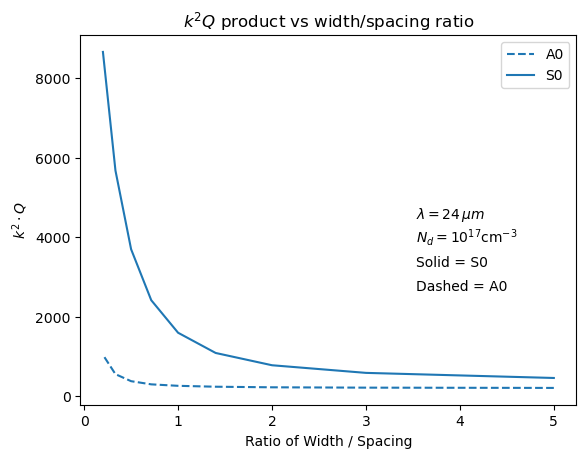

In [53]:
#Cell 105
lambda_sel = 24.0
Nd_idx    = 3          # 1e15 cm^-3
df['lambda_um']     = 2.0*(df['spacing_um'] + df['width_um'])
# keep only the relevant slice
dfA0 = df[(df['lambda_um']==lambda_sel) & (df['doping_idx']==Nd_idx) & (df['mode_idx'] == 0)] .copy()
dfS0 = df[(df['lambda_um']==lambda_sel) & (df['doping_idx']==Nd_idx) & (df['mode_idx'] == 1)] .copy()

# NaN/Inf guard for each plot
dfA0 = dfA0[np.isfinite(dfA0['k2_fd']) & np.isfinite(dfA0['Q'])].copy()
dfS0 = dfS0[np.isfinite(dfS0['k2_fd']) & np.isfinite(dfS0['Q'])].copy()

# derive axes
dfA0['w_s_ratio'] = dfA0['width_um'] / dfA0['spacing_um']
dfS0['w_s_ratio'] = dfS0['width_um'] / dfS0['spacing_um']
dfA0['k2Q'] = dfA0['k2_fd'] * dfA0['Q']
dfS0['k2Q'] = dfS0['k2_fd'] * dfS0['Q']

fig, ax = plt.subplots()
ax.plot(dfA0['w_s_ratio'], dfA0['k2Q'], color='tab:blue', linestyle='--', label='A0')
ax.plot(dfS0['w_s_ratio'], dfS0['k2Q'], color='tab:blue', linestyle='-', label='S0')
ax.annotate(r'$\lambda= 24\,\mu m$', xy=(0.65, 0.5), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'$N_d = 10^{17} \text{cm}^{-3}$', xy=(0.65, 0.45), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Dashed = A0', xy=(0.65, 0.35), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.65, 0.4), xycoords='figure fraction', color='k', fontsize=10)
ax.set_xlabel(r'Ratio of Width / Spacing')
ax.set_ylabel(r'$k^2 \cdot Q$')
ax.set_title(r'$k^2 Q$ product vs width/spacing ratio')
ax.legend(loc='upper right')


Let's confirm the wide spread between $k^2$ calculations by replotting the measured, estimate, and fitted. Add arrows of length indicating the $k^2$ value. For peak spacing, the arrow starts and stops at the max/min frequency. The estimate actually used the peak spacing from the measured curve. 
The measured and fitted are close, but the estimate isn't very good. 
What's it mean if 

In [ ]:
#cell 203

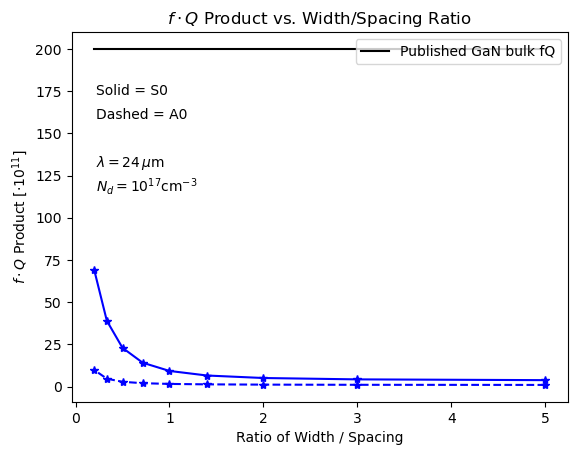

In [86]:
#Cell 203
lambda_sel = 24.0
Nd_idx    = 3         # 1e17 cm^-3
df['lambda_um'] = 2.0 * (df['spacing_um'] + df['width_um'])
dfA0 = df[(df['lambda_um'] == lambda_sel) & (df['doping_idx'] == Nd_idx) & (df['mode_idx'] == 0)].copy()
dfS0 = df[(df['lambda_um'] == lambda_sel) & (df['doping_idx'] == Nd_idx) & (df['mode_idx'] == 1)].copy()

df_Q_A0 = dfA0[np.isfinite(dfA0['Q']) & np.isfinite(dfA0['freq_Hz'])].copy()
df_Q_S0 = dfS0[np.isfinite(dfS0['Q']) & np.isfinite(dfS0['freq_Hz'])].copy()

df_Q_A0['w_s_ratio'] = df_Q_A0['width_um'] / df_Q_A0['spacing_um']
df_Q_S0['w_s_ratio'] = df_Q_S0['width_um'] / df_Q_S0['spacing_um']
df_Q_A0['fQ_scaled'] = df_Q_A0['freq_Hz'] * df_Q_A0['Q'] / 1e11
df_Q_S0['fQ_scaled'] = df_Q_S0['freq_Hz'] * df_Q_S0['Q'] / 1e11

fQ_line = 2.0e13 / 1e11
x_min = min(df_Q_A0['w_s_ratio'].min(), df_Q_S0['w_s_ratio'].min())
x_max = max(df_Q_A0['w_s_ratio'].max(), df_Q_S0['w_s_ratio'].max())

fig, ax = plt.subplots()
ax.plot(df_Q_A0['w_s_ratio'], df_Q_A0['fQ_scaled'], color='b', linestyle='--', marker='*')
ax.plot(df_Q_S0['w_s_ratio'], df_Q_S0['fQ_scaled'], color='b', linestyle='-', marker='*')
ax.plot([x_min, x_max], [fQ_line, fQ_line], color='k', linestyle='-', label='Published GaN bulk fQ')
ax.annotate(r'$\lambda = 24\,\mu\mathrm{m}$', xy=(0.15, 0.6), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate(r'$N_d = 10^{17} \text{cm}^{-3}$', xy=(0.15, 0.55), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Dashed = A0', xy=(0.15, 0.7), xycoords='figure fraction', color='k', fontsize=10)
ax.annotate('Solid = S0', xy=(0.15, 0.75), xycoords='figure fraction', color='k', fontsize=10)
ax.set_xlabel(r'Ratio of Width / Spacing')
ax.set_ylabel(r'$f \cdot Q$ Product $[\cdot 10^{11}]$')
ax.set_title(r'$f \cdot Q$ Product vs. Width/Spacing Ratio')
ax.legend(loc='upper right')


In [ ]:
#Cell 204 